# 1. Setup

## 1.1 Install Dependencies

In [120]:
!pip install tensorflow D matplotlib

You should consider upgrading via the 'C:\Users\sharm\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## 1.2 Import Dependencies

In [121]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [122]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [123]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [124]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [125]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [128]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [129]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [130]:
# Import uuid library to generate unique image names
import uuid

In [131]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\55de13a3-8677-11ec-8cdd-b0608845391c.jpg'

In [132]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

KeyboardInterrupt: 

# 2.x NEW - Data Augmentation

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
import os
import uuid

In [ ]:
img_path = os.path.join(ANC_PATH, '2b22b3a9-84b7-11ec-9cd9-b0608845391c.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [136]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [137]:
dir_test = anchor.as_numpy_iterator()

In [138]:
print(dir_test.next())

b'data\\anchor\\c9370f02-84b7-11ec-ac70-b0608845391c.jpg'


## 3.2 Preprocessing - Scale and Resize

In [139]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [140]:
img = preprocess('data\\anchor\\2b22b3a9-84b7-11ec-9cd9-b0608845391c.jpg')

In [141]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

In [144]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [145]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [146]:
samples = data.as_numpy_iterator()

In [147]:
exampple = samples.next()

In [148]:
exampple

(b'data\\anchor\\2b22b3a9-84b7-11ec-9cd9-b0608845391c.jpg',
 b'data\\positive\\d2535fea-84b7-11ec-ab1c-b0608845391c.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [149]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [150]:
res = preprocess_twin(*exampple)

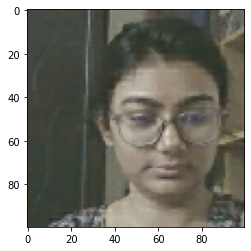

In [151]:
plt.imshow(res[1])

In [152]:
res[2]

1.0

In [153]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [154]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [155]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [211]:
inp = Input(shape=(100,100,3), name='input_image')

In [212]:
c1 = Conv2D(64, (10,10), activation='sigmoid')(inp)

In [213]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [214]:
c2 = Conv2D(128, (7,7), activation='sigmoid')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [215]:
c3 = Conv2D(128, (4,4), activation='sigmoid')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [216]:
c4 = Conv2D(256, (4,4), activation='sigmoid')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [217]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [218]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

In [429]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='sigmoid')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='sigmoid')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='sigmoid')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='sigmoid')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [430]:
embedding = make_embedding()

In [431]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [432]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [433]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [434]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [435]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [436]:
siamese_layer = L1Dist()

In [437]:
distances = siamese_layer(inp_embedding, val_embedding)

In [438]:
classifier = Dense(1, activation='sigmoid')(distances)

In [439]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_14')>

In [440]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [441]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [442]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [443]:
siamese_model = make_siamese_model()

In [444]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [445]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [446]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [447]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [448]:
test_batch = train_data.as_numpy_iterator()

In [449]:
batch_1 = test_batch.next()

In [450]:
X = batch_1[:2]

In [451]:
y = batch_1[2]

In [452]:
y

array([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [453]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_log

In [454]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [455]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [456]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [457]:
EPOCHS = 50

In [458]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 44s 12s/step
0.6931358 0.0 0.0

 Epoch 2/50
2/2 [==============================] - 41s 11s/step
0.6930496 0.0 0.0

 Epoch 3/50
2/2 [==============================] - 41s 11s/step
0.69299585 0.5833333 1.0

 Epoch 4/50
2/2 [==============================] - 41s 12s/step
0.6930004 0.75 0.9

 Epoch 5/50
2/2 [==============================] - 39s 11s/step
0.693033 0.78571427 0.9166667

 Epoch 6/50
2/2 [==============================] - 38s 10s/step
0.6928663 0.9230769 0.9230769

 Epoch 7/50
2/2 [==============================] - 38s 11s/step
0.6921589 1.0 0.73333335

 Epoch 8/50
2/2 [==============================] - 38s 10s/step
0.6913433 1.0 0.75

 Epoch 9/50
2/2 [==============================] - 38s 11s/step
0.68994904 1.0 0.78571427

 Epoch 10/50
2/2 [==============================] 

# 6. Evaluate Model

## 6.1 Import Metrics

In [459]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [523]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [524]:
y_hat = siamese_model.predict([test_input, test_val])

In [525]:
# Post processing the results 
[1 if prediction > 0.8 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

In [526]:
y_true

array([0., 1., 0., 0., 1., 0., 0., 1., 0., 1.], dtype=float32)

## 6.3 Calculate Metrics

In [527]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [528]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [529]:
m = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False
) 
# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [530]:
m = tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)
# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [531]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


## 6.4 Viz Results

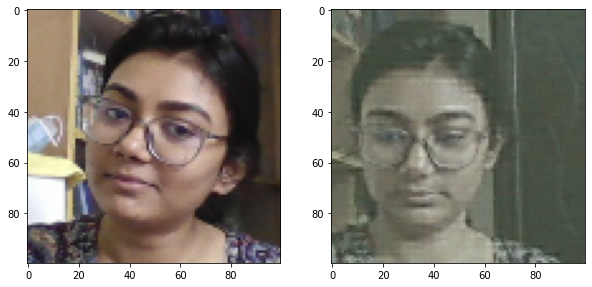

In [532]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# 7. Save Model

In [533]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [534]:
L1Dist

__main__.L1Dist

In [535]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [536]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.00375155],
       [0.9998133 ],
       [0.99521077],
       [0.9994645 ],
       [0.00268766],
       [0.0717386 ],
       [0.9321344 ],
       [0.01087412],
       [0.00861168],
       [0.99990714]], dtype=float32)

In [537]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [541]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (Temp/ipykernel_45368/2818603333.py, line 1)

In [542]:
os.listdir(os.path.join('application_data', 'verification_images'))

['4cd7f698-84b7-11ec-b78b-b0608845391c.jpg',
 '4e68ad5d-84b7-11ec-9529-b0608845391c.jpg',
 '53fa33c4-84b7-11ec-943b-b0608845391c.jpg',
 '58abc5b5-84b7-11ec-a364-b0608845391c.jpg',
 '5b8b31a4-84b7-11ec-84ac-b0608845391c.jpg',
 '75afdd56-84b7-11ec-91be-b0608845391c.jpg',
 '906e3934-84b7-11ec-b66b-b0608845391c.jpg',
 '906e76a2-84b7-11ec-8d65-b0608845391c.jpg',
 '906ee3e1-84b7-11ec-adea-b0608845391c.jpg',
 '906f3285-84b7-11ec-ba26-b0608845391c.jpg',
 '906f594b-84b7-11ec-b355-b0608845391c.jpg',
 '906f85ec-84b7-11ec-b3de-b0608845391c.jpg',
 '906fd496-84b7-11ec-b94b-b0608845391c.jpg',
 '90a00d8d-84b7-11ec-8fbe-b0608845391c.jpg',
 '90a07393-84b7-11ec-985e-b0608845391c.jpg',
 '90a11067-84b7-11ec-82e0-b0608845391c.jpg',
 '90a156ee-84b7-11ec-bfb7-b0608845391c.jpg',
 '90aae761-84b7-11ec-92b2-b0608845391c.jpg',
 '90ab5810-84b7-11ec-8cda-b0608845391c.jpg',
 '90abb4fd-84b7-11ec-be5a-b0608845391c.jpg',
 '90abfbd5-84b7-11ec-8c42-b0608845391c.jpg',
 '90ac4658-84b7-11ec-8389-b0608845391c.jpg',
 '90ac846f

In [543]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [544]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\4cd7f698-84b7-11ec-b78b-b0608845391c.jpg
application_data\verification_images\4e68ad5d-84b7-11ec-9529-b0608845391c.jpg
application_data\verification_images\53fa33c4-84b7-11ec-943b-b0608845391c.jpg
application_data\verification_images\58abc5b5-84b7-11ec-a364-b0608845391c.jpg
application_data\verification_images\5b8b31a4-84b7-11ec-84ac-b0608845391c.jpg
application_data\verification_images\75afdd56-84b7-11ec-91be-b0608845391c.jpg
application_data\verification_images\906e3934-84b7-11ec-b66b-b0608845391c.jpg
application_data\verification_images\906e76a2-84b7-11ec-8d65-b0608845391c.jpg
application_data\verification_images\906ee3e1-84b7-11ec-adea-b0608845391c.jpg
application_data\verification_images\906f3285-84b7-11ec-ba26-b0608845391c.jpg
application_data\verification_images\906f594b-84b7-11ec-b355-b0608845391c.jpg
application_data\verification_images\906f85ec-84b7-11ec-b3de-b0608845391c.jpg
application_data\verification_images\906fd496-84b7-11ec-b94b-b06

In [545]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [307]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False


In [308]:
np.sum(np.squeeze(results) > 0.9)

20

In [305]:
results

[array([[0.6342491]], dtype=float32),
 array([[0.6296574]], dtype=float32),
 array([[0.4894078]], dtype=float32),
 array([[0.503862]], dtype=float32),
 array([[0.44986317]], dtype=float32),
 array([[0.06412655]], dtype=float32),
 array([[0.07223573]], dtype=float32),
 array([[0.3898004]], dtype=float32),
 array([[0.2781703]], dtype=float32),
 array([[0.19228438]], dtype=float32),
 array([[0.39620203]], dtype=float32),
 array([[0.5840732]], dtype=float32),
 array([[0.7370438]], dtype=float32),
 array([[0.63012934]], dtype=float32),
 array([[0.80907416]], dtype=float32),
 array([[0.8913528]], dtype=float32),
 array([[0.93495715]], dtype=float32),
 array([[0.33963203]], dtype=float32),
 array([[0.23205805]], dtype=float32),
 array([[0.15980113]], dtype=float32),
 array([[0.37275785]], dtype=float32),
 array([[0.5327724]], dtype=float32),
 array([[0.67076445]], dtype=float32),
 array([[0.4660899]], dtype=float32),
 array([[0.6666291]], dtype=float32),
 array([[0.94165885]], dtype=float32),